<a href="https://colab.research.google.com/github/RoshanPAN/colab_notebooks/blob/main/pytorch_quick_start_Luoshang_Jan15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch 1.2 Quickstart with Google Colab
In this code tutorial we will learn how to quickly train a model to understand some of PyTorch's basic building blocks to train a deep learning model. This notebook is inspired by the ["Tensorflow 2.0 Quickstart for experts"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) notebook. 

After completion of this tutorial, you should be able to import data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for image classification.

**Author:** [Elvis Saravia](https://twitter.com/omarsar0)

**Complete Code Walkthrough:** [Blog post](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)

In [ ]:
# !pip3 uninstall torchvision
!pip3 install torch==1.13.0+cu116  -f https://download.pytorch.org/whl/torch_stable.html # torchvision==0.9.1+cu111
!pip3 install torchrec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.6/317.6 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 KB 23.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

Note: We will be using the latest stable version of PyTorch so be sure to run the command above to install the latest version of PyTorch, which as the time of this tutorial was 1.2.0. We PyTorch belowing using the `torch` module. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchrec
# import torchvision
# import torchvision.transforms as transforms
print(torch.__version__)

1.13.0+cu116


In [ ]:
import os
import torch
import torchrec
import torch.distributed as dist

os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29500"

# Note - you will need a V100 or A100 to run tutorial as as!
# If using an older GPU (such as colab free K80), 
# you will need to compile fbgemm with the appripriate CUDA architecture
# or run with "gloo" on CPUs 
dist.init_process_group(backend="nccl")

In [ ]:
ebc = torchrec.EmbeddingBagCollection(
    device="meta",
    tables=[
        torchrec.EmbeddingBagConfig(
            name="product_table",
            embedding_dim=64,
            num_embeddings=4096,
            feature_names=["product"],
            pooling=torchrec.PoolingType.SUM,
        ),
        torchrec.EmbeddingBagConfig(
            name="user_table",
            embedding_dim=64,
            num_embeddings=4096,
            feature_names=["user"],
            pooling=torchrec.PoolingType.SUM,
        )
    ]
)

In [ ]:
from torchrec.optim.apply_overlapped_optimizer import apply_overlapped_optimizer

apply_overlapped_optimizer(
    ebc.parameters(),
    optimizer_type=torch.optim.SGD,
    optimizer_kwargs={"lr": 0.02},
)

In [ ]:
model = torchrec.distributed.DistributedModelParallel(ebc, device=torch.device("cuda"))
print(model)
print(model.plan)

DistributedModelParallel(
  (_dmp_wrapped_module): ShardedEmbeddingBagCollection(
    (lookups): 
     GroupedPooledEmbeddingsLookup(
        (_emb_modules): ModuleList(
          (0): BatchedFusedEmbeddingBag(
            (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
          )
        )
        (_score_emb_modules): ModuleList()
      )
     (_output_dists): 
     TwPooledEmbeddingDist(
        (_dist): PooledEmbeddingsAllToAll()
      )
    (_input_dists): ModuleList()
    (_lookups): ModuleList(
      (0): GroupedPooledEmbeddingsLookup(
        (_emb_modules): ModuleList(
          (0): BatchedFusedEmbeddingBag(
            (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
          )
        )
        (_score_emb_modules): ModuleList()
      )
    )
    (_output_dists): ModuleList(
      (0): TwPooledEmbeddingDist(
        (_dist): PooledEmbeddingsAllToAll()
      )
    )
  )
)
{'': {'product_table': ParameterSharding(sharding_type='table_wise', compute_kernel='fuse

In [ ]:
from torchrec.distributed.fbgemm_qcomm_codec import get_qcomm_codecs_registry, QCommsConfig, CommType
from torchrec.distributed.embeddingbag import EmbeddingBagCollectionSharder

sharder = EmbeddingBagCollectionSharder(
    qcomm_codecs_registry=get_qcomm_codecs_registry(
            qcomms_config=QCommsConfig(
                forward_precision=CommType.FP16,
                backward_precision=CommType.BF16,
            )
        )
)
model = torchrec.distributed.DistributedModelParallel(ebc, sharders=[sharder], device=torch.device("cuda"))

In [ ]:
product_eb = torch.nn.EmbeddingBag(4096, 64)
product_eb(input=torch.tensor([101, 202, 303]), offsets=torch.tensor([0, 2, 2]))

tensor([[-0.6645, -1.4839, -0.0569,  0.8944,  2.4186,  0.0227,  1.0029, -0.6602,
          1.0186, -0.7351, -1.1619, -1.4583, -0.6978,  1.3495,  0.7533, -0.2423,
         -0.0375,  0.3004, -0.1910,  1.4390, -0.4510,  1.2134,  0.5641, -1.1812,
         -0.4082, -0.1815, -0.4184,  0.1335, -0.1494, -1.1686,  0.0927, -0.5570,
         -0.3412,  0.3418, -0.1518, -0.1652, -0.2961, -0.5735,  0.3383, -0.1959,
          0.1078, -0.2904,  0.0960,  0.3101, -0.1779, -0.3172, -0.2015,  0.3363,
         -0.7161, -0.9023, -0.5943, -0.0071, -0.1969,  1.7662, -0.4355,  0.6728,
         -0.1358, -0.6523, -0.1524, -0.3256,  0.9686, -0.4752,  0.8857,  0.1342],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 

In [ ]:
mb = torchrec.KeyedJaggedTensor(
    keys = ["product", "user"],
    values = torch.tensor([101, 202, 303, 404, 505, 606]).cuda(),
    lengths = torch.tensor([2, 0, 1, 1, 1, 1], dtype=torch.int64).cuda(),
)

print(mb.to(torch.device("cpu")))

KeyedJaggedTensor({
    "product": [[101, 202], [], [303]],
    "user": [[404], [505], [606]]
})



In [ ]:
pooled_embeddings = model(mb).to_dict()
print("product embeddings", pooled_embeddings["product"])
print("user embeddings", pooled_embeddings["user"])

product embeddings tensor([[-0.0057, -0.0044,  0.0004,  0.0023,  0.0051, -0.0142,  0.0002, -0.0221,
          0.0069,  0.0084,  0.0024,  0.0075,  0.0092,  0.0077,  0.0095, -0.0054,
          0.0183, -0.0143,  0.0003, -0.0170, -0.0213, -0.0233,  0.0124, -0.0156,
          0.0019, -0.0145, -0.0147, -0.0091, -0.0270, -0.0104,  0.0031,  0.0195,
         -0.0001,  0.0179, -0.0005,  0.0278,  0.0020,  0.0243, -0.0187,  0.0098,
          0.0077, -0.0079, -0.0133, -0.0047, -0.0031,  0.0186,  0.0211,  0.0101,
          0.0037,  0.0052,  0.0087, -0.0227,  0.0216, -0.0035,  0.0076,  0.0174,
         -0.0028,  0.0006,  0.0057, -0.0160,  0.0019,  0.0268, -0.0010,  0.0022],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        

## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:02, 3643813.85it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57582.77it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 973571.63it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 21777.08it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order. 

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

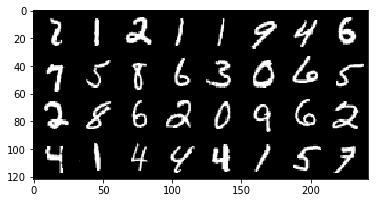

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

**EXERCISE:** Try to understand what the code above is doing. This will help you to better understand your dataset before moving forward. 

Let's check the dimensions of a batch.

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect. 

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.4901 | Train Accuracy: 96.97
Epoch: 1 | Loss: 1.4808 | Train Accuracy: 97.90
Epoch: 2 | Loss: 1.4767 | Train Accuracy: 98.34
Epoch: 3 | Loss: 1.4748 | Train Accuracy: 98.55
Epoch: 4 | Loss: 1.4725 | Train Accuracy: 98.81


We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.04


**EXERCISE:** As a way to practise, try to include the testing part inside the code where I was outputing the training accuracy, so that you can also keep testing the model on the testing data as you proceed with the training steps. This is useful as sometimes you don't want to wait until your model has completed training to actually test the model with the testing data.

## Final Words
That's it for this tutorial! Congratulations! You are now able to implement a basic CNN model in PyTorch for image classification. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling, but as you saw, you don't really need it here as results look good. If you are interested in implementing a similar image classification model using RNNs see the references below. 

## References
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) 